Here are the categories in the Fashion-MNIST

|Label | Class |
|-|-|
|0|	T-shirt/top|
|1|	Trouser|
|2|	Pullover|
|3|	Dress|
|4|	Coat|
|5|	Sandal|
|6|	Shirt|
|7|	Sneaker|
|8|	Bag|
|9|	Ankle boot|



### The training dataset comprises of 60,000 instances and the testing dataset comprises of 10,000 instances. The images have just one channel because they are gray scale images.

# Ready to work

In [6]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

Define some global variables

In [7]:
# training batches of our network
EPOCHS = 5
# size of each batch
BATCH_SIZE = 64

DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(torch.__version__)
print(DEVICE)

1.10.0+cu111
cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [8]:
# you can change the path if need be to make it work on colab
train_csv = pd.read_csv('/content/drive/MyDrive/fashion-mnist_train.csv')
test_csv = pd.read_csv('/content/drive/MyDrive/fashion-mnist_test.csv')


print(train_csv.shape)
print(test_csv.shape)

(60000, 785)
(10000, 785)


In [5]:
print(train_csv.info())
print(train_csv.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
None
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0    

In [9]:
print(test_csv.info())
print(test_csv.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB
None
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      0       0       0       0       0       0       0       0       9   
1      1       0       0       0       0       0       0       0       0   
2      2       0       0       0       0       0       0      14      53   
3      2       0       0       0       0       0       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       8  ...       103        87        56         0         0         0   
1       0  ...        34         0         0         0         0         0   
2      99  ...         0         0         0         0        63        53   
3       0  ...       137       126       140         0       133      

As the output, the first row is the label of each image, and each image has 784 pixels

## Dataset

In [10]:
class FashionDataset(Dataset):
    def __init__(self, data, transform=None):        
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label, image = [], []
        
        for i in self.fashion_MNIST:
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28).astype('float32')
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]      
        
        if self.transform is not None:
            # transfrom the numpy array to PIL image before the transform function
            pil_image = Image.fromarray(np.uint8(image)) 
            image = self.transform(pil_image)
            
        return image, label

## Transform

Because the input size of AlexNet is $227*227$, and the image size of Fashion-MNIST is $28*28$, so we need to resize the image in the transform function. Since `transforms.Resize()` only works to the PIL Image,we transform the numpy array to PIL Image above

In [11]:
AlexTransform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # official mean and standard deviation of the fashion mnist dataset.
])

## DataLoader

In [12]:
# load training data
train_loader = DataLoader(
    FashionDataset(train_csv, transform=AlexTransform), 
    batch_size=BATCH_SIZE, shuffle=True)

# load testing data
test_loader = DataLoader(
    FashionDataset(test_csv, transform=AlexTransform), 
    batch_size=BATCH_SIZE, shuffle=True)

## Show images

Shirt


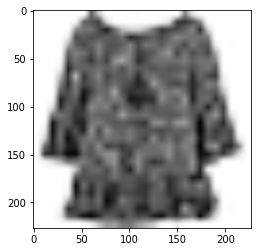

In [13]:
# helper function to show an image
def matplotlib_imshow(img):
    img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg, cmap="Greys")

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# creat grid of images
img_grid = torchvision.utils.make_grid(images[0])

# show images & labels
matplotlib_imshow(img_grid)
print(class_names[labels[0]])

# AlexNet

![](https://i.loli.net/2020/02/17/xd6oNRpWSK1cZy2.png)

In [14]:
# in layer 1 we have in_channels = 1 since the image is gray scale.
# alexnet implementation
# no of output channels in the final full connected layer is 3
class fasion_mnist_alexnet(nn.Module):  
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        # fully connected layers, 4096 * 4096 = 256 * 6 * 6
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)

        out = F.relu(self.fc1(out))  # 256*6*6 -> 4096
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)

        return out


# model


In [15]:
model = fasion_mnist_alexnet().to(DEVICE) # attaching the device to which gpu is currently active
criterion = F.nll_loss
optimizer = optim.Adam(model.parameters()) # used the adam optimizer instead of sgd as an experiment

## train funation

In [16]:
def train(model, device, train_loader, optimer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 30 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

## test function


In [17]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)  # loss -> mean
        print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        print('='*50)


# Begin to Train

In [18]:
# the accuracy increase as the number of epochs are increased
for epoch in range(1, EPOCHS+1):
    train(model, DEVICE, train_loader, optimizer, epoch)
    test(model, DEVICE, test_loader)

Train Epoch:1 [1856/60000 (3%)]	Loss: 1.275515
Train Epoch:1 [3776/60000 (6%)]	Loss: 1.063237
Train Epoch:1 [5696/60000 (9%)]	Loss: 0.631029
Train Epoch:1 [7616/60000 (13%)]	Loss: 0.672628
Train Epoch:1 [9536/60000 (16%)]	Loss: 0.872189
Train Epoch:1 [11456/60000 (19%)]	Loss: 0.349507
Train Epoch:1 [13376/60000 (22%)]	Loss: 0.544889
Train Epoch:1 [15296/60000 (25%)]	Loss: 0.531889
Train Epoch:1 [17216/60000 (29%)]	Loss: 0.459904
Train Epoch:1 [19136/60000 (32%)]	Loss: 0.401788
Train Epoch:1 [21056/60000 (35%)]	Loss: 0.588005
Train Epoch:1 [22976/60000 (38%)]	Loss: 0.370931
Train Epoch:1 [24896/60000 (41%)]	Loss: 0.314519
Train Epoch:1 [26816/60000 (45%)]	Loss: 0.252456
Train Epoch:1 [28736/60000 (48%)]	Loss: 0.363886
Train Epoch:1 [30656/60000 (51%)]	Loss: 0.272032
Train Epoch:1 [32576/60000 (54%)]	Loss: 0.273779
Train Epoch:1 [34496/60000 (57%)]	Loss: 0.401314
Train Epoch:1 [36416/60000 (61%)]	Loss: 0.553794
Train Epoch:1 [38336/60000 (64%)]	Loss: 0.160597
Train Epoch:1 [40256/60000 (